# Description
The goal of this report is to give policy makers a more complete picture of the state of elementary enrollment in the Eau Claire area school district. My hope is that this analysis will aid in making informed decisions about demographic issues in the future.

The data for this report was gathered from the last seven years of third Friday enrollment numbers. I have aggregated the data in various ways to illustrate metrics that I believe could be helpful.

There are various points in this report where I made analysis that was not available in the third Friday enrollment reports. When this occurs, I have made a note of it in the analysis.

Though I am not a statistician, I have been a software engineer for twenty years and I have used my background to provide this data, to the best of my ability.

# Compiling the Initial Dataset
The third Friday counts were acquired by an open record request. They were provided as a PDF[1], so I manually extracted the data into a spreadsheet, then parsed using Python[2] and Pandas[3].

In [1]:
from pyexcel_ods3 import get_data
import numpy as np
import pandas as pd
from IPython.display import display, Markdown, Latex
from matplotlib import pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from numbers import Number
from matplotlib.ticker import FuncFormatter
from ipywidgets import HBox, VBox


def as_percent(v, precision='0.2'):
    """Convert number to percentage string."""
    if isinstance(v, Number):
        return "{{:{}%}}".format(precision).format(v)
    else:
        raise TypeError("Numeric type required")

        
def as_year_interval(v):
    return pd.DateOffset(years=v)


register_matplotlib_converters()
pd.options.display.max_rows = 14

df = pd.DataFrame()
for date, rows in get_data("Third Friday.ods").items():
    ydf = pd.DataFrame(rows[1:], columns=rows[0])
    ydf['Date'] = pd.to_datetime(date)
    ydf = ydf.replace(r'^\s*$', np.NaN, regex=True)
    ydf['School'] = ydf['School'].fillna(method='ffill')
    ydf = pd.melt(ydf, id_vars=['Date', 'School'], var_name='Grade', value_name='Students')
    ydf = ydf[ydf['Students'].notnull()]

    df = df.append(ydf)

df['Students'] = df['Students'].astype('int')
df['School Year'] = pd.Categorical(df['Date'].apply(lambda x: "{} / {}".format(x.strftime('%Y'), int(x.strftime('%Y')) + 1)), ordered=True)
df['Grade'] = pd.Categorical(df['Grade'], ['Grade K', 'Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'])

# df['Cohort Group'] = df['School Year'].cat.codes - df['Grade'].cat.codes
df['Cohort Group'] = (df['Date'].dt.strftime('%Y').astype('int') - df['Grade'].cat.codes).apply(lambda x: "{} / {}".format(x, x + 1))

display(df.set_index(['School Year','School','Grade'])[['Students']])

Students
School Year School    Grade            
2019 / 2020 Davey     Grade K        20
                      Grade K        18
                      Grade K        19
            Flynn     Grade K        11
                      Grade K        12
...                                 ...
2013 / 2014 Roosevelt Grade 5        20
                      Grade 5        21
            Sherman   Grade 5        23
                      Grade 5        22
                      Grade 5        23

[1489 rows x 1 columns]

# Per-School Classroom Usage Analysis
When the number of classrooms at a school exceed the number of available classrooms, schools are faced with a difficult decision about where to put these "overflow" classrooms. Frequently, other services at the school are sacraficed to make room. Computer labs, special education rooms, and hallways become educational spaces. These are not ideal outcomes, so it's critical that policy makers are aware of this measurement.

*Editorial decision: I do not have exact educational classroom counts for each school. I have made an estimation that it is `6 * the stated number of sections for the school`.*

In [2]:
classrooms_per_school_year = df[['School Year','School','Students']].groupby(['School Year','School']).count().rename(columns={'Students':'Classrooms in Use'})

cdf = pd.DataFrame([('Davey', 18),('Flynn', 12),('Lakeshore', 18),('Locust Lane', 18),('Longfellow', 18),('Manz', 18),('Meadowview', 18),('Northwoods', 18),('Putnam Heights', 18),('Robbins', 24),('Roosevelt',12),('Sherman',24)], columns=['School','Available Classrooms'])
classroom_utilization_per_school_year = classrooms_per_school_year.reset_index().merge(cdf)

for schoolName, school_classroom_utilization_per_year in classroom_utilization_per_school_year.groupby(['School']):
    display(Markdown(f'## {schoolName}'))
    display(school_classroom_utilization_per_year.set_index(['School Year']).sort_values('School Year', ascending=False)[['Classrooms in Use', 'Available Classrooms']])

## Davey

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,15,18
2018 / 2019,15,18
2017 / 2018,16,18
2016 / 2017,17,18
2015 / 2016,17,18
2014 / 2015,17,18
2013 / 2014,18,18


## Flynn

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,14,12
2018 / 2019,14,12
2017 / 2018,14,12
2016 / 2017,15,12
2015 / 2016,16,12
2014 / 2015,16,12
2013 / 2014,15,12


## Lakeshore

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,21,18
2018 / 2019,20,18
2017 / 2018,19,18
2016 / 2017,21,18
2015 / 2016,23,18
2014 / 2015,23,18
2013 / 2014,23,18


## Locust Lane

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,15,18
2018 / 2019,14,18
2017 / 2018,13,18
2016 / 2017,13,18
2015 / 2016,16,18
2014 / 2015,16,18
2013 / 2014,16,18


## Longfellow

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,15,18
2018 / 2019,14,18
2017 / 2018,14,18
2016 / 2017,14,18
2015 / 2016,16,18
2014 / 2015,16,18
2013 / 2014,17,18


## Manz

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,18,18
2018 / 2019,21,18
2017 / 2018,20,18
2016 / 2017,19,18
2015 / 2016,18,18
2014 / 2015,17,18
2013 / 2014,17,18


## Meadowview

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,19,18
2018 / 2019,20,18
2017 / 2018,20,18
2016 / 2017,20,18
2015 / 2016,19,18
2014 / 2015,18,18
2013 / 2014,18,18


## Northwoods

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,17,18
2018 / 2019,18,18
2017 / 2018,18,18
2016 / 2017,18,18
2015 / 2016,18,18
2014 / 2015,17,18
2013 / 2014,17,18


## Putnam Heights

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,18,18
2018 / 2019,18,18
2017 / 2018,18,18
2016 / 2017,18,18
2015 / 2016,17,18
2014 / 2015,17,18
2013 / 2014,18,18


## Robbins

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,23,24
2018 / 2019,21,24
2017 / 2018,22,24
2016 / 2017,22,24
2015 / 2016,20,24
2014 / 2015,21,24
2013 / 2014,24,24


## Roosevelt

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,12,12
2018 / 2019,12,12
2017 / 2018,12,12
2016 / 2017,13,12
2015 / 2016,14,12
2014 / 2015,15,12
2013 / 2014,13,12


## Sherman

,Classrooms in Use,Available Classrooms
School Year,,
2019 / 2020,22,24
2018 / 2019,20,24
2017 / 2018,21,24
2016 / 2017,22,24
2015 / 2016,23,24
2014 / 2015,24,24
2013 / 2014,24,24


Before we can compare these numbers against each other, we must apply the same scale to the data. By taking `Classroms in Use / Available Classrooms`, we can see the utilization percent of each school.

*Editorial decision: I have choosen 100% as the center of the heatmap color gradient.*

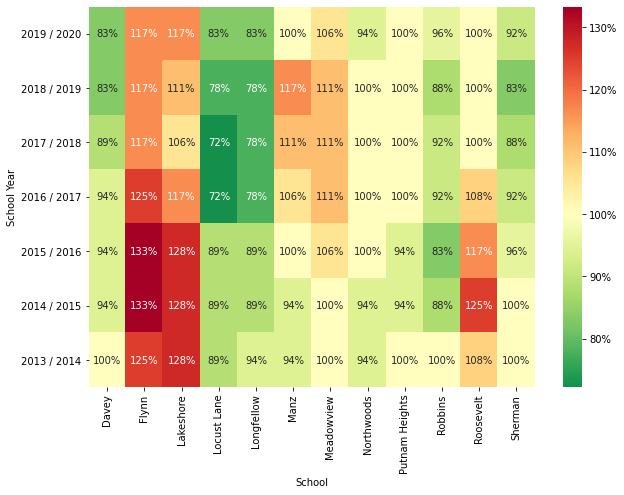

\pagebreak

In [3]:
classroom_utilization_per_school_year['Classroom Utilization Ratio'] = (classroom_utilization_per_school_year['Classrooms in Use'] / classroom_utilization_per_school_year['Available Classrooms'])
classroom_utilization_per_school_year['Classroom Utilization Percent'] = classroom_utilization_per_school_year['Classroom Utilization Ratio']

classroom_utilization_per_school_year = classroom_utilization_per_school_year[['School Year','School','Classroom Utilization Percent']].set_index(['School Year','School']).unstack()['Classroom Utilization Percent'].sort_values('School Year', ascending=False)

fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(classroom_utilization_per_school_year, center=1, annot=True, cmap="RdYlGn_r", ax=ax, fmt='.0%', cbar_kws={'format': FuncFormatter(lambda x,pos: '{:.0%}'.format(x))})

plt.yticks(rotation=0)
plt.show()
display(Markdown('\pagebreak'))

# Per-Grade Seat Usage Analysis
The Per-School Classroom Usage analysis provides a good snapshot of the amount of stress a schools enrollment numbers are causing, but it is a step-wise measurement. There are cases where an increase of students at one school will not affect this the classroom usage, but the same increase at another school will increase that schools classroom usage.

By measuring the number of seats in use, per-grade, against the available seats in the school, we can see how close schools are to needing additional classrooms.

*Editorial decision: I have selected a center of 85% for the heatmap color gradient.*

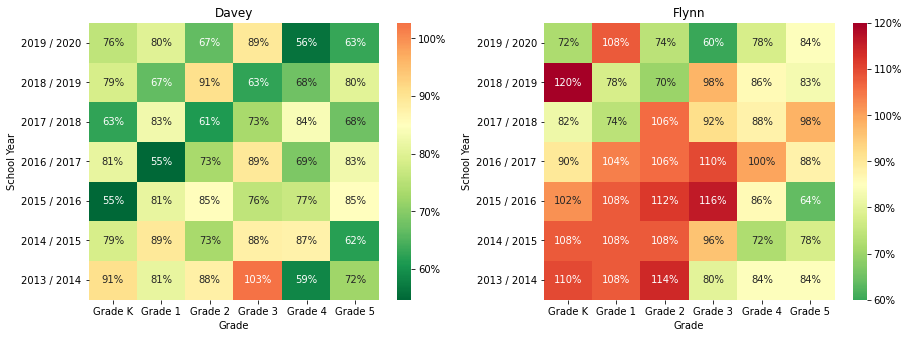

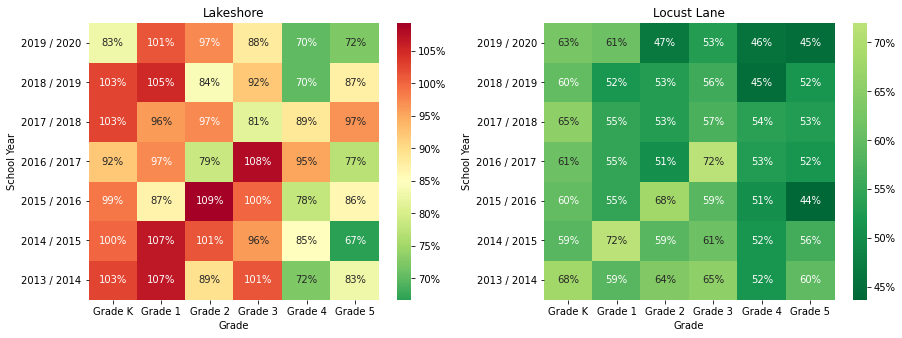

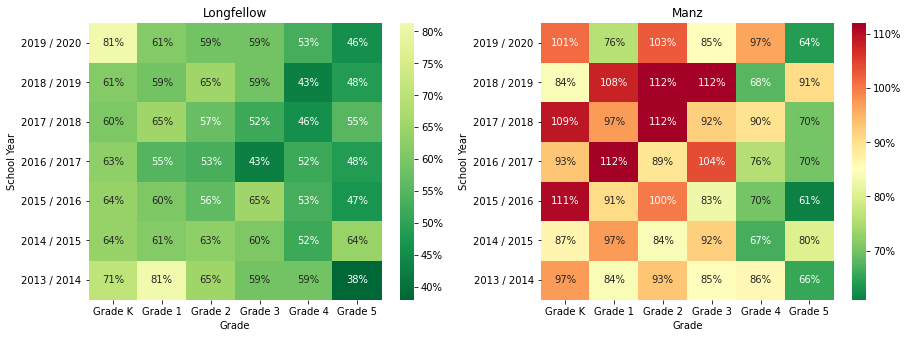

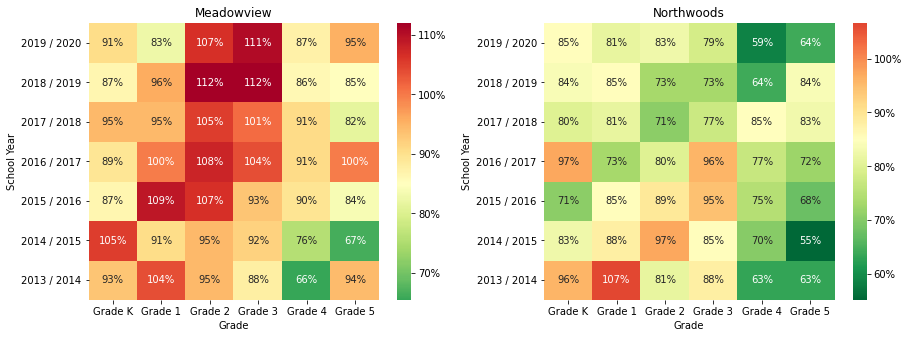

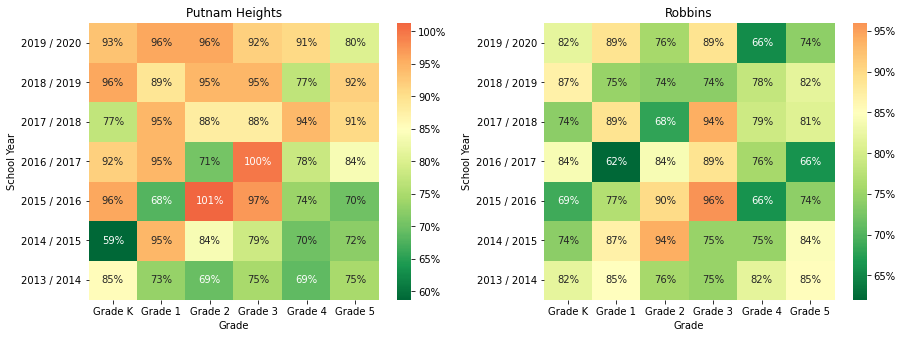

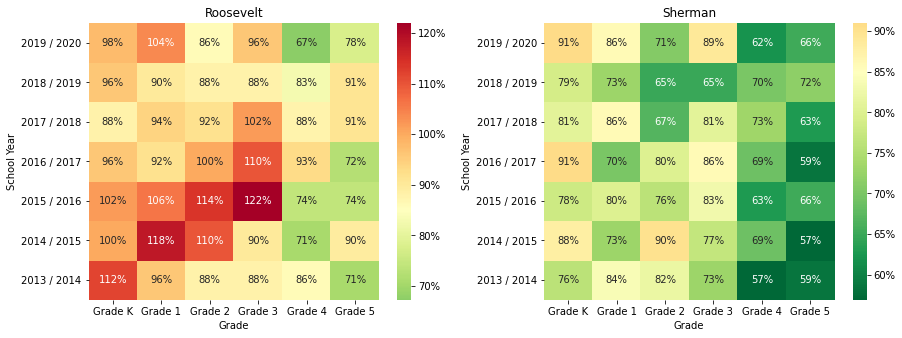

In [4]:
school_grade_capacity = pd.DataFrame([
    ('Davey','Grade K',75),('Davey','Grade 1',75),('Davey','Grade 2',75),('Davey','Grade 3',75),('Davey','Grade 4',87),('Davey','Grade 5',87),
    ('Flynn','Grade K',50),('Flynn','Grade 1',50),('Flynn','Grade 2',50),('Flynn','Grade 3',50),('Flynn','Grade 4',58),('Flynn','Grade 5',58),
    ('Lakeshore','Grade K',75),('Lakeshore','Grade 1',75),('Lakeshore','Grade 2',75),('Lakeshore','Grade 3',75),('Lakeshore','Grade 4',87),('Lakeshore','Grade 5',87),
    ('Locust Lane','Grade K',75),('Locust Lane','Grade 1',75),('Locust Lane','Grade 2',75),('Locust Lane','Grade 3',75),('Locust Lane','Grade 4',87),('Locust Lane','Grade 5',87),
    ('Longfellow','Grade K',75),('Longfellow','Grade 1',75),('Longfellow','Grade 2',75),('Longfellow','Grade 3',75),('Longfellow','Grade 4',87),('Longfellow','Grade 5',87),
    ('Manz','Grade K',75),('Manz','Grade 1',75),('Manz','Grade 2',75),('Manz','Grade 3',75),('Manz','Grade 4',87),('Manz','Grade 5',87),
    ('Meadowview','Grade K',75),('Meadowview','Grade 1',75),('Meadowview','Grade 2',75),('Meadowview','Grade 3',75),('Meadowview','Grade 4',87),('Meadowview','Grade 5',87),
    ('Northwoods','Grade K',75),('Northwoods','Grade 1',75),('Northwoods','Grade 2',75),('Northwoods','Grade 3',75),('Northwoods','Grade 4',87),('Northwoods','Grade 5',87),
    ('Putnam Heights','Grade K',75),('Putnam Heights','Grade 1',75),('Putnam Heights','Grade 2',75),('Putnam Heights','Grade 3',75),('Putnam Heights','Grade 4',87),('Putnam Heights','Grade 5',87),
    ('Robbins','Grade K',100),('Robbins','Grade 1',100),('Robbins','Grade 2',100),('Robbins','Grade 3',100),('Robbins','Grade 4',116),('Robbins','Grade 5',116),
    ('Roosevelt','Grade K',50),('Roosevelt','Grade 1',50),('Roosevelt','Grade 2',50),('Roosevelt','Grade 3',50),('Roosevelt','Grade 4',58),('Roosevelt','Grade 5',58),
    ('Sherman','Grade K',100),('Sherman','Grade 1',100),('Sherman','Grade 2',100),('Sherman','Grade 3',100),('Sherman','Grade 4',116),('Sherman','Grade 5',116)
], columns=['School','Grade','Maximum Capacity']).reset_index()

students_per_grade = df.groupby(['School Year','School','Grade']).sum().reset_index().merge(school_grade_capacity)
students_per_grade['Grade'] = pd.Categorical(students_per_grade['Grade'], ['Grade K', 'Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'])

del students_per_grade['index']

students_per_grade['Capacity Ratio'] = students_per_grade['Students'] / students_per_grade['Maximum Capacity']
students_per_grade['Capacity Ratio'] = students_per_grade['Capacity Ratio']
students_per_grade['Capacity Percent'] = students_per_grade['Capacity Ratio'].apply(as_percent)

i = 0
for school_name, school_capacity_ratio in students_per_grade.groupby(['School']):
    if i % 2 == 0:
        fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(6.4 * 2, 4.8))
    else:
        ax = ax2
        
    sns.heatmap(school_capacity_ratio.sort_values('Grade').set_index(['School Year', 'Grade']).unstack()['Capacity Ratio'], center=.85, annot=True, cmap="RdYlGn_r", fmt='.0%', cbar_kws={'format': FuncFormatter(lambda x,pos: '{:.0%}'.format(x))}, ax=ax)
    ax.invert_yaxis()
    ax.set_title(school_name)
    
    i += 1
    
    if i // 2 != 0 and i % 2 == 0:
        plt.tight_layout()
        plt.show()

### Observations
The district classroom size guidelines difference for K-3 and 4-5 are clearly visible in the heatmap.

Schools under stress -- Manz, Meadowview, Putnam Heights, and Roosevelt -- are easily identified by their heatmaps.

Cohort groups are easily identified by their diagonal progression in the heatmap.

# Cohort Counts
Cohort analysis is frequently used by school districts to make projections.

\pagebreak

## District

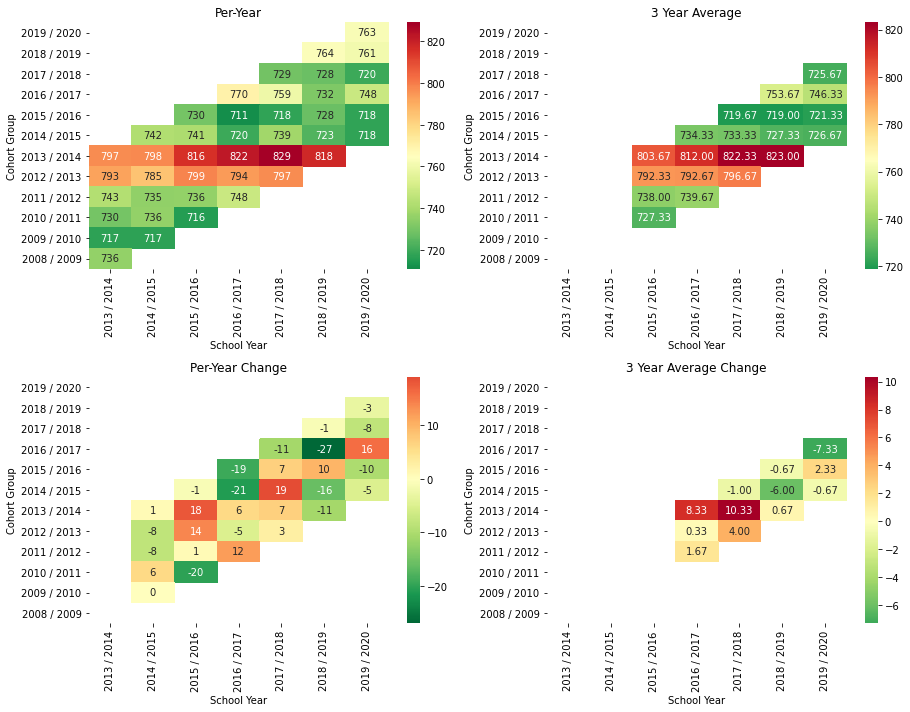

***

## Davey

In [ ]:
cohort_group_sum = df.groupby(['Cohort Group','School Year'])['Students'].sum()

cohort_group_rolling_mean = df.groupby(['Cohort Group','School Year'])['Students'].sum().rolling(3).mean()
cohort_group_rolling_mean_change = cohort_group_rolling_mean.diff()

display(Markdown('\pagebreak'))
display(Markdown('## District'))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 10))
ax1.set_title('Per-Year')
ax2.set_title('3 Year Average')
ax3.set_title('Per-Year Change')
ax4.set_title('3 Year Average Change')

center = school_grade_capacity[school_grade_capacity['Grade'] == 'Grade K']['Maximum Capacity'].sum() * .85

sns.heatmap(cohort_group_sum.unstack().sort_values('Cohort Group', ascending=False), annot=True, fmt='g', ax=ax1, center=center, cmap="RdYlGn_r")
sns.heatmap(cohort_group_rolling_mean.unstack().sort_values('Cohort Group', ascending=False), annot=True, fmt='.2f', ax=ax2, center=center, cmap="RdYlGn_r")

sns.heatmap(cohort_group_sum.diff().unstack().sort_values('Cohort Group', ascending=False), annot=True, fmt='g', ax=ax3, center=0, cmap="RdYlGn_r")
sns.heatmap(cohort_group_rolling_mean_change.unstack().sort_values('Cohort Group', ascending=False), annot=True, fmt='.2f', ax=ax4, center=0, cmap="RdYlGn_r")

plt.tight_layout()
plt.show()

for school_name, school_df in df.groupby(['School']):
    display(Markdown('***'))
    
    school_cohort_group_sum = school_df.groupby(['Cohort Group','School Year'])['Students'].sum()

    display(Markdown('## {}'.format(school_name)))
    
    school_cohort_group_rolling_mean = school_df.groupby(['Cohort Group','School Year'])['Students'].sum().rolling(3).mean()
    school_cohort_group_rolling_mean_change = school_cohort_group_rolling_mean.diff()
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 10))
    ax1.set_title('Per-Year')
    ax2.set_title('3 Year Average')
    ax3.set_title('Per-Year Change')
    ax4.set_title('3 Year Average Change')

    center = school_grade_capacity[(school_grade_capacity['School'] == school_name) & (school_grade_capacity['Grade'] == 'Grade K')]['Maximum Capacity'].iloc[0] * .75
    
    sns.heatmap(school_cohort_group_sum.unstack().sort_values('Cohort Group', ascending=False), annot=True, ax=ax1, center=center, cmap="RdYlGn_r")
    sns.heatmap(school_cohort_group_rolling_mean.unstack().sort_values('Cohort Group', ascending=False), annot=True, ax=ax2, center=center, cmap="RdYlGn_r", fmt='.2f')

    sns.heatmap(school_cohort_group_sum.diff().unstack().sort_values('Cohort Group', ascending=False), annot=True, center=0, ax=ax3, cmap="RdYlGn_r")
    sns.heatmap(school_cohort_group_rolling_mean_change.unstack().sort_values('Cohort Group', ascending=False), annot=True, center=0, ax=ax4, cmap="RdYlGn_r", fmt='.2f')
    
    plt.tight_layout()
    plt.show()